In [24]:
# Import libraries

from scipy.stats import boxcox
import numpy as np
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [25]:
# Load input csv (energia and meteo)
df_energia_2021 = pd.read_csv('../input/energia_202109-202112.csv', encoding='latin-1', na_values=["", "NaN", ""])
df_energia_2022 = pd.read_csv('../input/energia_202201-202212.csv', encoding='latin-1', na_values=["", "NaN", ""])
df_meteo_2021 = pd.read_csv('../input/meteo_202109-202112.csv', encoding='latin-1', na_values=["", "NaN", ""])
df_meteo_2022 = pd.read_csv('../input/meteo_202201-202212.csv', encoding='latin-1', na_values=["", "NaN", ""])

train_energia = pd.concat([df_energia_2021, df_energia_2022])
train_meteo = pd.concat([df_meteo_2021, df_meteo_2022])

test_energia_X = pd.read_csv('../input/energia_202301-202304.csv', encoding='latin-1')
test_meteo_X = pd.read_csv('../input/meteo_202301-202304.csv', encoding='latin-1')

In [26]:
'''
Inspect data
'''
print(train_meteo.columns)


Index(['dt', 'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'wind_speed', 'rain_1h', 'clouds_all', 'weather_description'],
      dtype='object')


In [27]:
train_meteo.head()

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1630454400,2021-09-01 00:00:00 +0000 UTC,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00 +0000 UTC,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00 +0000 UTC,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00 +0000 UTC,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00 +0000 UTC,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain


In [28]:
print("----------------------------------------------")
print(train_meteo.info())
print(test_meteo_X.info())

'''
In meteo dataset, there are null entries in columns sea_level, grnd_level, and rain_1h, the first two all of them being null
'''

----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 11688 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   11688 non-null  int64  
 1   dt_iso               11688 non-null  object 
 2   city_name            11688 non-null  object 
 3   temp                 11688 non-null  float64
 4   feels_like           11688 non-null  float64
 5   temp_min             11688 non-null  float64
 6   temp_max             11688 non-null  float64
 7   pressure             11688 non-null  int64  
 8   sea_level            0 non-null      float64
 9   grnd_level           0 non-null      float64
 10  humidity             11688 non-null  int64  
 11  wind_speed           11688 non-null  float64
 12  rain_1h              2435 non-null   float64
 13  clouds_all           11688 non-null  int64  
 14  weather_description  11688 non-null  object 


'\nIn meteo dataset, there are null entries in columns sea_level, grnd_level, and rain_1h, the first two all of them being null\n'

In [29]:
print(train_meteo.nunique())

dt                     11688
dt_iso                 11688
city_name                  1
temp                    2423
feels_like              2702
temp_min                 488
temp_max                 550
pressure                  41
sea_level                  0
grnd_level                 0
humidity                  82
wind_speed               771
rain_1h                  371
clouds_all               101
weather_description        8
dtype: int64


In [30]:

print(train_meteo.describe())

'''
Description of each of the datasets
'''

                 dt          temp    feels_like      temp_min      temp_max  \
count  1.168800e+04  11688.000000  11688.000000  11688.000000  11688.000000   
mean   1.651491e+09     16.406638     16.076164     14.433353     17.502990   
std    1.214705e+07      5.715977      6.217605      4.960590      6.112344   
min    1.630454e+09      0.320000     -2.190000     -0.640000      1.330000   
25%    1.640973e+09     12.350000     11.760000     10.900000     12.930000   
50%    1.651491e+09     15.760000     15.675000     14.540000     16.720000   
75%    1.662009e+09     19.540000     19.560000     17.720000     20.700000   
max    1.672528e+09     40.850000     41.330000     36.720000     41.450000   

           pressure  sea_level  grnd_level      humidity    wind_speed  \
count  11688.000000        0.0         0.0  11688.000000  11688.000000   
mean    1018.304073        NaN         NaN     76.619011      2.647688   
std        6.109727        NaN         NaN     16.157421      1.45

'\nDescription of each of the datasets\n'

In [31]:
print(train_meteo[["feels_like", "temp", "temp_min", "temp_max"]].isnull().sum())
"----"
print(test_meteo_X[["feels_like", "temp", "temp_min", "temp_max"]].isnull().sum())


feels_like    0
temp          0
temp_min      0
temp_max      0
dtype: int64
feels_like    0
temp          0
temp_min      0
temp_max      0
dtype: int64


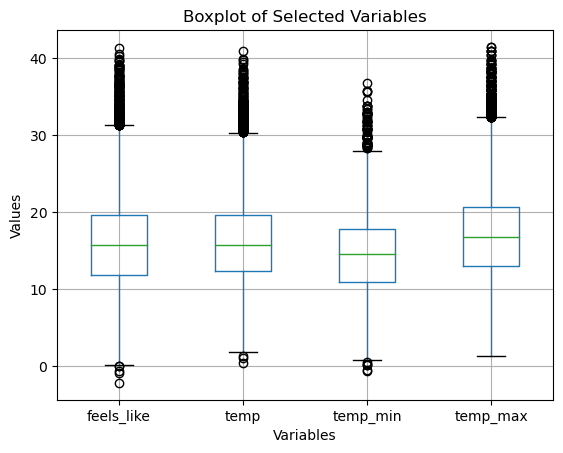

In [32]:
columns_to_boxplot = ["feels_like", "temp", "temp_min", "temp_max"]

# Creating the boxplot
train_meteo[columns_to_boxplot].boxplot()

# Setting labels and title
plt.xlabel("Variables")
plt.ylabel("Values")
plt.title("Boxplot of Selected Variables")

# Display the plot
plt.show()

In [41]:
# List of variables to calculate skewness and kurtosis
variables_to_analyze = ["feels_like", "temp", "temp_min", "temp_max"]

# Calculate and print skewness for each variable
for variable in variables_to_analyze:
    skewness = train_meteo[variable].skew()
    print(f"Skewness for {variable}: {skewness}")

# Calculate and print kurtosis for each variable
for variable in variables_to_analyze:
    kurtosis = train_meteo[variable].kurt()
    print(f"Kurtosis for {variable}: {kurtosis}")


Skewness for feels_like: 0.5537350589884252
Skewness for temp: 0.6485272767252105
Skewness for temp_min: 0.22796433942287875
Skewness for temp_max: 0.8005668807788181
Kurtosis for feels_like: 0.5885049727707328
Kurtosis for temp: 0.5647711891238303
Kurtosis for temp_min: 0.3474900842142845
Kurtosis for temp_max: 0.6376252253221208


/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


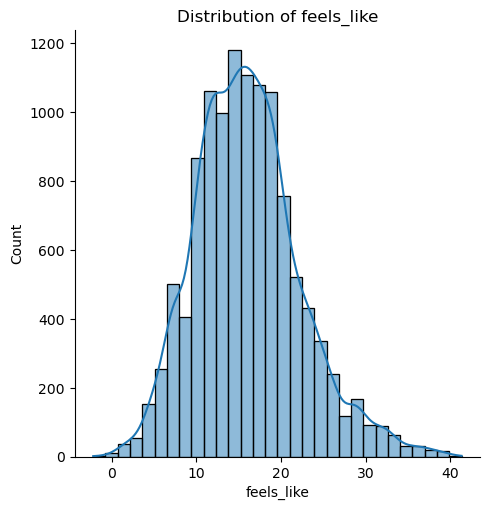

/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


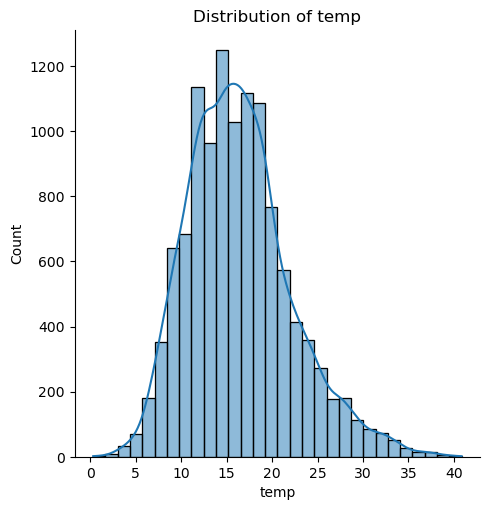

/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


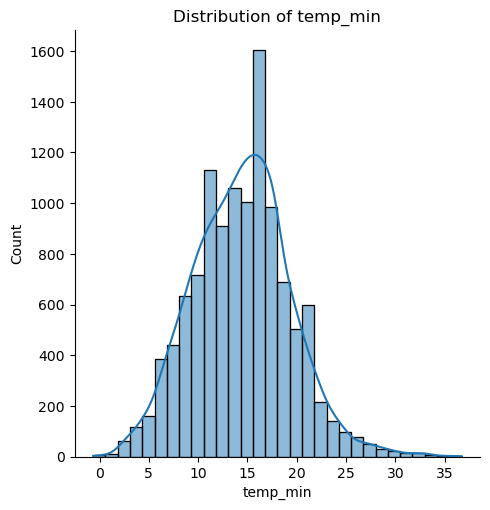

/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ricardoaraujo/miniconda3/envs/mypython3version/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


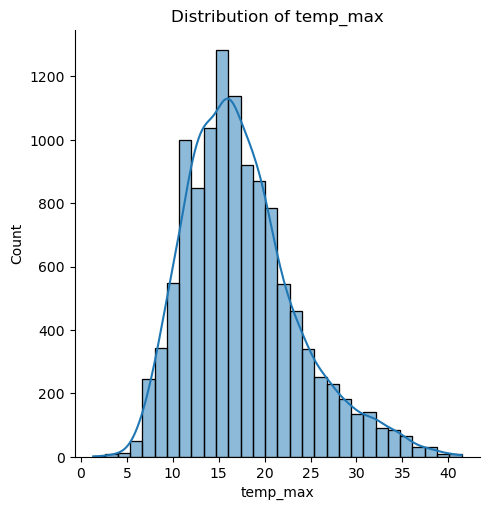

In [44]:


# Use displot without figsize in a loop
for col in variables_to_analyze:
    sns.displot(train_meteo[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()
